#  Modelo de predição <br />

## Sumário:

   ## 1. Introdução
      1.1  Objetivo 
      1.2  Bibliotecas
      
   ## 2. Dados 
      2.1 Ler os dados
      2.2 Ler os dados pré-processados:
      2.3 Separando os dados :
       
   ## 3. Pré-processadores
      3.1 Criando o pré-processador
      3.2 Funções de limpeza de dados testadas:
      3.3 Funções de padronização e normalização testadas:
      3.4 Funções para encoding:
       
   ## 4.  Fluxo de processos com Pipeline:
      4.1 Modelos de classificação testados  
          4.11  K Nearest Neighbors
          4.12  Support Vector Machine
          4.13  Árvore de decisão
          4.14  Regressão logística
      4.2 Pipeline
      4.3 Dicionário de pipelines
       
       
   ## 5. Validação cruzada: Avaliando o desempenho do estimador
   
   ## 6. Ajuste fino de parâmetros:
       
      6.1 Parâmetros dos modelos de Machine Learning
      6.2 Aplicando a técnica Grid search
       
   ## 7. Seleção de Features
      7.1 Definindo o melhor k para a função de seleção de Features: SelectKBest()
      7.2 Gráficos de K vs mean absolute error (MAE)
      7.3 Adicionando a função SelectKBest() ao Pipeline
       
   ## 8.  Persistindo os modelos para o disco
   
   ## 9.  Verificando quais funcionários valiosos sairão da empresa:
       
      9.1 Filtro: Melhores funcionários
      9.2 Modelo escolhido para a solução
      9.3 Importância das Features
      9.4 Solução


## 1. Introdução

#### 1.1 Objetivo:
* Verificar quais funcionários valiosos sairão da empresa.

#### 1.2  Bibliotecas:

In [2]:
import import_ipynb            # Permite "importar"  outros arquivos  ipynb 
import os                      # Para criar Diretórios

import pandas as pd
import numpy as np

from sklearn.model_selection   import train_test_split
from sklearn                   import neighbors   
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.tree              import DecisionTreeClassifier
from sklearn.impute            import SimpleImputer
from sklearn.compose           import ColumnTransformer
from sklearn.model_selection   import GridSearchCV

from joblib import dump, load  # Persistir os modelos para o disco

# Módulos que eu criei 
import __Pre_Processamento__
from   __Pre_Processamento__   import Pre_Processamento_inicial, Separar

# Seleção de Features:
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.compose           import make_column_transformer
from sklearn.metrics           import mean_absolute_error

#Gráficos
import matplotlib.pyplot

importing Jupyter notebook from __Pre_Processamento__.ipynb


## 2. Dados

#### 2.1 Ler os dados 

In [3]:
dados = pd.read_csv("HR_Engagement_Sat_Sales_UpdatedV4.0.csv",index_col=0)

#### 2.2 Ler os dados pré-processados: 

In [4]:
dados_ler  = Pre_Processamento_inicial(dados, Premissas_1 = True)
dados_processados_inicialmente = dados_ler.dados_processados_inicialmente

#### 2.3 Separando os dados :

O médodo "separando" da classe "Separar()" permite separar  os dados de acordo com a estrutura que o modelo ML exige, ou seja,  X = features e y target.                                                 
Os dados categóricos e contínuos podem ser separados usando as propriedades do método "separando".

In [2]:
Sep =  Separar()                                                # Instanciando  a classe 
Sep.separando("left_Company", dados_processados_inicialmente)   # separando("Target", dados)
X = Sep.X # Features 
y = Sep.y # Target

# Propriedades do método separando - Separando dados categóricos e contínuos.
categorical_features =  Sep.Colunas_dados_categoricos           # dados categóricos
numeric_features     =  Sep.Colunas_dados_numericos             # dados contínuos

## 3.  Pré-processadores

#### 3.1 Criando o  pré-processador

* O Scikit-learn a partir da versão 0.20 fornece  a função  sklearn.compose.ColumnTransformer para fazer o transformador de coluna com tipos mistos. Pode-se escalar  as features  numéricas e codificar as categóricos no mesmo processo.
* Cuidado: este método é EXPERIMENTAL, alguns comportamentos podem mudar entre os lançamentos sem depreciação.

#### 3.2 Funções de limpeza de dados testadas: 
   3.21  SimpleImputer(): 
   Tratar  dados faltantes utilizando a classe SimpleImputer da biblioteca sklearn.impute.Lembrando que já foi realizado um tratamento inicial de dados faltantes, de acordo  com as premissas iniciais.

#### 3.3 Funções de padronização e normalização testadas: 

3.31 StandardScaler() 
   * Eficiente para features com distribuição   normal.
   * Para cada feature, o StandardScaler()  dimensiona os valores de forma que a média seja 0 e o desvio padrão seja 1 (ou a variância).
   * O StandardScaler assume que a distribuição da variável é normal. Assim, caso as variáveis não sejam normalmente distribuídas, pode-se : 
        * Escolher um dimensionador diferente
        * Converter as variáveis para uma distribuição normal e, em seguida, aplicar  o StandardScaler

3.32 MaxAbsScaler() 
   * Pega o valor máximo absoluto de cada coluna e divide cada valor na coluna pelo valor máximo.

   * Primeiro obtém-se o valor absoluto de cada valor na coluna e, em seguida, obtém o valor máximo. 
      Esta operação dimensiona os dados entre o intervalo [-1, 1].

3.33 MinMaxScaler() 
   * O dimensionador MinMax é um dos dimensionadores mais simples de entender. Ele apenas dimensiona todos os dados entre 0       e 1.
 
####  3.4 Funções para encoding:

3.41 One-Hot Encoding:

   * A variável categórica não é ordinal.
   * O número de recursos categóricos é menor, então a codificação one-hot pode ser aplicada com eficácia


3.42 Aplicamos a codificação de Label Encoding quando:

   * A variável categórica é ordinal ('ruim', 'médio', 'bom')
   * O número de categorias é bastante grande, pois a codificação one-hot pode levar a um alto consumo de memória 

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor_1 = ColumnTransformer(
 transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [7]:
preprocessor_2 = Pipeline(steps=
      [
     ("ohe", OneHotEncoder(handle_unknown="ignore")
     )])  

## 4. Fluxo de processos com Pipeline:
O objetivo das  pipelines é reunir várias etapas que podem ser validadas em conjunto ao se definir parâmetros diferentes.

Pelas característica do problema, vemos que é um problema para Aprendizagem de Máquina Supervisionada.
Devido a natureza dos dados e o fato da variável de predição ser discreta

#### 4.1 Modelos de classificação testados :  

#### 4.1.1  K Nearest Neighbors
    4.1.1.1  É automaticamente não linear, pode detectar dados distribuídos lineares ou não lineares, tende a ter um desempenho muito bom com muitos pontos de dados.

    4.1.1.2  Precisa ser cuidadosamente ajustado, a escolha de K e a métrica (distância) a ser usada são críticas.  para muitos pontos de dados, o KNN tem problemas de desempenho. 

    4.1.1.3  É muito sensível a recursos ruins (atributos), portanto a seleção de recursos também é importante. O KNN também é sensível a valores discrepantes e a remoção deles antes de usá-lo tende a melhorar os resultados.
    
    
#### 4.1.2  Support Vector Machine

    4.1.2.1  O SVM pode ser usado de maneiras lineares ou não lineares com o uso de um Kernel, quando se tem um conjunto limitado de pontos em muitas dimensões, o SVM tende a ser muito bom porque deve ser capaz de encontrar a separação linear que possivelmente  existe. 
    
    4.1.2.2  É bom para outliers, pois usará apenas os pontos mais relevantes para encontrar uma separação linear (vetores de suporte)

    4.1.2.3  Precisa ser ajustado, o custo "C" e o uso de um kernel e  hiperparâmetros são  críticos para o algoritmo. 

#### 4.1.3  Árvore de decisão

Algumas vantagens: 

    4.1.3.1  Útil em exploração de dados: A árvore de decisão é uma das formas mais rápidas de identificar as variáveis mais   significativas e a relação entre duas ou mais variáveis. Com a ajuda de árvores de decisão, podemos criar novas variáveis/características que tenham melhores condições de predizer a variável alvo. 
    
    4.1.3.2  Menor necessidade de limpar dados: Requer menos limpeza de dados em comparação com outras técnicas de modelagem. Até um certo nível, não é influenciado por pontos fora da curva “outliers” nem por valores faltantes (“missing values”).
    
    4.1.3.3  Não é restrito por tipos de dados: Pode manipular variáveis numéricas e categóricas.
    
    4.1.3.4  Método não paramétrico: A árvore de decisão é considerada um método não-paramétrico. Isto significa que as árvores de decisão não pressupõe a distribuição do espaço nem a estrutura do classificador.

Algumas desvantagens:

    4.1.3.5  Sobreajuste (“Over fitting”): Sobreajuste é uma das maiores dificuldades para os modelos de árvores de decisão. 
    
    4.1.3.6  Não adequado para variáveis contínuas: ao trabalhar com variáveis numéricas contínuas, a árvore de decisão perde informações quando categoriza variáveis em diferentes categorias.
    
    4.1.3.7  Decision-trees can handle categorical values very well but most of the algorithms expect numerical values to achieve state-of-the-art results.
    
    4.1.3.8 A codificação Label Encoding  converte dados categóricos para inteiros e o DecisionTreeClassifier() tratará como dados numéricos. Se seus dados categóricos não forem ordinais, isso não é bom - pode ocorrer divisões que não fazem sentido.
  
    4.1.3.9 A codificação one-hot pode degradar seriamente o desempenho do modelo de árvore
 
#### 4.1.4  Regressão logística

    4.1.4.1  A regressão logística é o método usado para problemas de classificação binária (problemas com dois valores de classe), utilizando conceitos de estatística e probabilidade
    
    4.1.4.2  A documentação de sklearn.linear_model.LogisticRegression mostra que o primeiro parâmetro é:
    Penalidade: str, 'l1' ou 'l2', padrão: 'l2' - Usado para especificar a norma usada na penalização. Os solvers ‘newton-cg’, ‘sag’ e ‘lbfgs’ suportam apenas 12 penalidades.
    A regularização torna o modelo dependente da escala das features. Recomendada-se  normalizar as features ao fazer regressão logística com regularização. Os autores do livro Elements of  Statistical Learning recomendam o uso do StandardScaler().

Algumas vantagens: 
    
    4.1.4.3  A regressão logística é um dos algoritmos de aprendizado de máquina mais simples e é fácil de implementar,fornece grande eficiência.Por esses motivos, treinar um modelo com esse algoritmo não requer alto poder de computação.

    4.1.4.4  A regressão logística produz resultados de em termos de probabilidades. Esta é uma vantagem sobre os modelos que fornecem apenas a classificação final como resultado. 

Algumas desvantagens:

    4.1.4.5  A regressão logística requer moderada ou nenhuma multicolinearidade entre as variáveis independentes. Isso significa que se duas variáveis independentes têm uma correlação alta, apenas uma delas deve ser usada. A repetição de informações pode levar ao treinamento incorreto de parâmetros (pesos) durante a minimização da função de custo. A multicolinearidade pode ser removida usando técnicas de redução de dimensionalidade.

    4.1.4.6  Apenas features importantes e relevantes devem ser usadas para construir o modelo, caso contrário, as previsões probabilísticas feitas pelo modelo podem estar incorretas e o valor preditivo do modelo pode degradar.


Entre o SVM e KNN: 

-  Muitos pontos em um espaço de baixa dimensão, o KNN provavelmente é uma boa escolha.

-  Alguns pontos em um espaço dimensional alto, provavelmente um SVM linear é melhor.

Como na base de dados os espaços dimensionais tem bastante pontos,  o Support Vector Machine demoraria muito para rodar na máquina que estou usando. Os demais foram todos testados.

#### 4.2 Pipelines:

In [8]:
knn_pip_1 = Pipeline([
              ('preprocessor_1', preprocessor_1)       
             ,("knn" , KNeighborsClassifier(n_neighbors=8))                        # Foi realizado ajuste fino de parâmetros:
             
             ])

logreg_pip_1 = Pipeline([
              ('preprocessor_2',preprocessor_2)                                    # [4.1.4.5, 4.1.4.2]
             ,("logreg" , LogisticRegression(C=0.1, max_iter = 2000))              # Foi realizado ajuste fino de parâmetros:
             ])

tree_pip_1 = Pipeline([
              ('preprocessor_1',preprocessor_1)
             ,("tree" , DecisionTreeClassifier(criterion='entropy', max_depth= 12)) # Foi realizado ajuste fino de parâmetros:
             ])
Pipelines = [knn_pip_1, logreg_pip_1 , tree_pip_1]

#### 4.3 Dicionário de pipelines:

In [ ]:
classification_models = {
                        ' knn_pip_1'   : knn_pip_1
                        ,'tree_pip_1'  : tree_pip_1
                        ,'logreg_pip_1': logreg_pip_1
                        }

## 5. Validação cruzada: Avaliando o desempenho do estimador
* Criando um conjunto de treinamento e  mantendo 20% dos dados para testar (avaliar) nosso classificador:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2) 

## 6. Ajuste fino de parâmetros: 

Ao avaliar diferentes configurações ("hiperparâmetros") para estimadores, não se deve ajustar os parãmetros manualmente, isso pode gerar overfitting.Os parâmetros podem acabar sendo  ajustados até que o estimador tenha um desempenho ideal. 

Para resolver este problema, separa-se um  "conjunto de validação": o treinamento é feito no  conjunto de treinamento, após isso  a avaliação é feita no conjunto de validação, e quando o experimento for  bem sucedido , a avaliação final será  feita no conjunto de teste.

No entanto, ao particionar os dados disponíveis em três conjuntos, reduzimos drasticamente o número de amostras que podem ser usadas para o modelo.

A solução é usar a  técnica "grid search"

#### 6.1 Parâmetros dos modelos de Machine Learning:

In [9]:
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']

# Quanto maior for max_depth, maior será o número de divisões na árvore de decisão, e portanto, mais informação o modelo captura dos dados
# max_depth não pode ser muito alto pois pode gerar superajuste  modelo 
max_depth = [10,12,14,16]


In [30]:
#Convenção  = '<named_step>__<parameter>':value 
param_grid_knn   = {'knn__n_neighbors': np.arange(4, 20,1)}
param_grid_LR    = {"logreg__C":np.logspace(-1,1,7)}# l1 lasso l2 ridge , "logreg__penalty":["l1","l2"]
param_grid_tree  = {"tree__criterion" :criterion, "tree__max_depth":max_depth }


param_grid = [param_grid_knn, param_grid_LR, param_grid_tree]

#### 6.2 Aplicando a técnica Grid search

In [31]:
for i, pip in enumerate(Pipelines):
    
    grid = GridSearchCV(pip, param_grid[i] , cv=5, scoring = "accuracy")
    grid.fit(X, y)
    
    print('best_score  pip_{} = {}'. format(i+1, grid.best_score_))
    print('best_params pip_{} = {}'. format(i+1, grid.best_params_))
    print(125*"-")

best_score  pip_1 = 0.9581333111037011
best_params pip_1 = {'knn__n_neighbors': 8}
-----------------------------------------------------------------------------------------------------------------------------
best_score  pip_2 = 0.9284660886962322
best_params pip_2 = {'logreg__C': 0.1}
-----------------------------------------------------------------------------------------------------------------------------
best_score  pip_3 = 0.8862666666666665
best_params pip_3 = {'tree__criterion': 'gini', 'tree__max_depth': 10}
-----------------------------------------------------------------------------------------------------------------------------


## 7. Seleção de Features

#### 7.1 Definindo o melhor k para a função de seleção de Features: SelectKBest()

In [9]:
#odelo_selec = logreg_pip_1                # Modelo usado para Seleção de Features 
modelo_selec  = tree_pip_1                 # Falta automatizar essa parte do código  

In [10]:
pre_processador = modelo_selec.steps[0][1] # Chamando o pré-processador da PipeLine
X_2 = pre_processador.fit_transform(X)     # Fit_transform: O fit salva o modelo de pré-processador 
                                           # O transform vai aplicar o pré-processador e criar um array X_2  

In [12]:
X_2.shape                                  # Verificando  as dimensões de x para definir o range de k 

(14999, 48)

In [20]:
#### Seleção de Features

k_vs_score = []                            # lista para ser usada na
suporte    = []                            # lista para ser usada na
score_list = []                            # lista para ser usada na

#for k in range(2500, 3000,50):
for k in range(10, 49,1):    
    score_list   = {}                      #Dicionário {k:mean_absolute_error}
    score_media  = []
    
    # Estrutura de loop
    # Esse loop tem a função de diminuir um pouco a variação nos resultados de mean_absolute_error.
    # Funciona pois a função split está dentro do loop.
    for i in range(1,10):
        
        #Criando um conjunto de treinamento e mantendo 20% dos dados para testar (avaliar) o melhor k:
        #Esse segundo split serve unicamente para o propósito  do cálculo de k 
        X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y, test_size= 0.2) 
        
        # Esse método seleciona as k features mais correlacionadas com o alvo 
        selector = SelectKBest(score_func = f_classif, k = k ) 

        # fit_transform: O fit faz o cálculo das correlações e armazena no objeto selector 
        # e o transform vai criar um array só com as melhores k colunas 
        X_train_new = selector.fit_transform(X_train_2, y_train_2)
        X_test_new  = selector.transform(X_test_2)


        modelo_selec.steps[1][1].fit(X_train_new,  y_train_2)
        Predict_Selec = modelo_selec.steps[1][1].predict(X_test_new)
        
        
        #MAE (mean absolut error): calcula o "erro absoluto médio" dos erros entre valores observados (reais) e predições (hipóteses).
        score_ = mean_absolute_error(y_test_2, Predict_Selec)
        score_list[k] = (score_)               #Dicionário {k:score_} 
        
    score_media.append(score_list[k])          # Salvando os valores do índice k
   
    score_m = sum(score_media)/len(score_media)# Cáculo da média 
    k_vs_score.append(score_m)                 # Salvando os mean_absolute_error médios


#### 7.2  Gráficos de K vs mean absolute error (MAE)

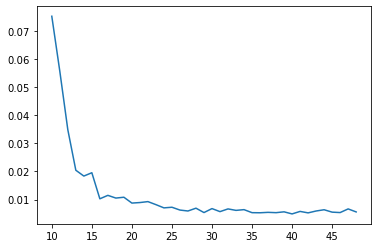

In [21]:
matplotlib.pyplot.plot(range(10, 49,1), k_vs_score)

 * Para a  pipeline logreg_pip_1, o k escolhido por inspeção gráfica será 2800 
 * Para as pipelines  knn_pip_1 e tree_pip_1, o k escolhido por inspeção gráfica será 48

#### 7.3 Adicionando a função  SelectKBest() ao Pipeline:

In [10]:
for i, model in enumerate(Pipelines):
    
    # Estrutura condicional:
    # Pré-Processadores diferentes podem gerar  a matriz de  feature "X"  com quantidades  diferentes  de colunas.
    # Logo, o valor de k também muda 
    if model.steps[0][0] == "preprocessor_1":
        k = 48
    elif model.steps[0][0] == "preprocessor_2":
        k = 2800 

    # Adicionando a função SelectKBest() ao Pipeline
    model.steps.insert(1,['SelectKBest', SelectKBest(score_func = f_classif, k = 48 )]) #inserir no 2º passo da Pipeline

## 8. Persistindo  os modelos  para o disco:
* Resultados usando os  parâmetros otimizados, sem usar a função Grid Search
* Persistência dos modelos com Joblib 

In [15]:
for name, model in classification_models.items():
    model.fit(X_train, y_train)
    
    #Persistindo os resultados  para o disco: 
    if not os.path.exists('{}.joblib'.format(name)):
        dump(model, '{}.joblib'.format(name))
        print("O modelo "+ name +" foi salvo com sucesso !")
    else:
        print("O modelo  " + name + " já foi salvo anteriormente")
        
    print('Score\t{}'.format( model.score(X_test, y_test)))

O modelo   knn_pip_1 já foi salvo anteriormente
Score	0.9623333333333334
O modelo  tree_pip_1 já foi salvo anteriormente
Score	0.9933333333333333
O modelo  logreg_pip_1 já foi salvo anteriormente
Score	0.945


## 9. Verificando quais funcionários valiosos sairão da empresa:

#### 9.1 Filtro: Melhores funcionários:
* Melhores funcionários de acordo com a métrica  "last_evaluation".  Foi aplicado o filtro  ["last_evaluation"> = 0.87] para definir os melhores  funcionários.Esse valor foi obtido apartir da análise estatística. 

In [18]:
def Filtro_melhores_funcionarios(df):
    X_new = df[df["left_Company"]!=1]                 #Tirando os que já sairam, queremos prever o que ocorrerá com os que ainda estão na empresa
    X_new = X_new[X_new["last_evaluation"]>=0.870000] # Separando os melhores funcionários.
    X_new = X_new.drop(columns = "left_Company")      # Preparando os dados para o modelo de Machine Learning 
    return X_new

In [19]:
X_new = Filtro_melhores_funcionarios(dados_processados_inicialmente)  # Dados dos melhores funcionários

#### 9.2 Modelo escolhido para a solução:
O modelo escolhido foi o de regressão logística, pois  busca-se respostas em termos de probabilidade

In [22]:
clf = load('logreg_pip_1.joblib')                                     # Carregando os dados persistidos

#### 9.3  Importância das Features

In [23]:
resultado = (clf.predict_proba(X_new))[:,1]

###### Obs:
A função predict_proba () retorna um array numpy de duas colunas.
A primeira coluna é a probabilidade de que alvo = 0 e a segunda coluna é a probabilidade de que alvo = 1.
É por isso que adicionamos [:, 1] depois de predict_proba () para obter as probabilidades de alvo = 1.

In [24]:
X_new["probabilidade_de_sair"] = resultado                              # acrescentando a solução ao X_new

In [25]:
solucao = (X_new["probabilidade_de_sair"]).sort_values(ascending=False) # Colocando a resposta em ordem decrescente. 
dump(solucao, 'probabilidade_de_sair.joblib')

['probabilidade_de_sair.joblib']

#### 9.4 Solução:
* Melhores funcionários de acordo com a métrica  "last_evaluation".  Foi aplicado o filtro  ["last_evaluation"> = 0.87] para definir os melhores  funcionários.Esse valor foi obtido apartir da análise estatística. 
* Os resultados indicam as probabilidades de saída.

In [61]:
solucao.head(20)

ID
11270    0.930213
12077    0.866904
11308    0.756495
13532    0.725005
13283    0.710506
11665    0.704853
12467    0.699241
12369    0.684611
11373    0.668930
11828    0.634668
14319    0.593065
11427    0.584484
14554    0.578534
14368    0.527817
14024    0.521074
12066    0.446229
11561    0.395535
14643    0.385875
11358    0.380550
12401    0.373675
Name: probabilidade_de_sair, dtype: float64

####  Referências 
https://iq.opengenus.org/advantages-and-disadvantages-of-logistic-regression/

https://www.mariofilho.com/as-metricas-mais-populares-para-avaliar-modelos-de-machine-learning/